Title: Server_Client_TFFEMNIST_CIF_Group

Purpose: This is the group code intended to be updated by all

Contains: TFF-EMNIST database, CIF (Data Quality + SINR) function

Date of Creation: November 25th, 2020

### Import all Packages ###

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import collections
import nest_asyncio
%reload_ext tensorboard
nest_asyncio.apply()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

### Load in TFF - EMNIST Data Set ###

In [2]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(only_digits=True)

### Create a Server Class ###

In [3]:
class server:
    
    def __init__(self, numOfClients):
        self.numOfClients = numOfClients #Num of Client
        self.clientIds = list(range(0,self.numOfClients)) #Client List
        self.updateRoundNum = 0  # Update Round Number
        self.serverModel = self.createBaseModel() #Create a Keras Model for MNIST
        self.clientActive = [] #If client is available or not based on time - day/night
        self.clientCIF = []
        self.clientSelected = []
        self.maxClientsPerRound = 10
        self.updateFromClients=[]
        self.__serverTestData_X=[]
        self.__serverTestData_Y=[]
        self.__serverTestData = self.setServerTestDataTFF(emnist_test)
        self.predictionAcc=[]
        self.predictionLoss=[]
        
        
    def createBaseModel(self):
        #return tf.keras.models.Sequential([
        #    Dense(64, activation='relu',input_shape=(784,)),
        #    Dense(64, activation='relu'),
        #    Dense(10, activation='softmax'),])
        return tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(784,)),
            tf.keras.layers.Dense(10, kernel_initializer='zeros'),
            tf.keras.layers.Softmax()])
    
    def setServerTestData(self,Xtest,Ytest):  # NOT USED IN THIS CASE
        self.__serverTestData_X=Xtest
        self.__serverTestData_Y=Ytest
        
    def setServerTestDataTFF(self,serverTestData):  #Creates a test set for server
        BATCH_SIZE = 1000
        SHUFFLE_BUFFER = 100
        PREFETCH_BUFFER= 10

        def preprocess(dataset):
            def batch_format_fn(element):
                """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
                return collections.OrderedDict(
                    x=tf.reshape(element['pixels'], [-1, 784]),
                    y=tf.reshape(element['label'], [-1, 1]))

            return dataset.repeat(10).shuffle(SHUFFLE_BUFFER).batch(
              BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)
        
        serverData1 = serverTestData.create_tf_dataset_for_client(serverTestData.client_ids[10])
        for i in range (2000,2500):
            serverData1 = serverData1.concatenate(serverTestData.create_tf_dataset_for_client(serverTestData.client_ids[i]))
            
        serverData =tfds.as_numpy(preprocess(serverData1))
        return serverData
     
        
    def initialBroadcast(self):
        for i in self.clientIds:
            clientName = client_list["client_"+str(self.clientIds[i])]  #Create Client Name, Using Client_List Dictionary
            #clientName = "client_"+str(self.clientIds[i])  #Create Client Name
            #print(clientName)
            clientName.setInitialModel(self.serverModel) #setInitialModel-> Method of client Class
            #eval(clientName).setInitialModel(self.serverModel) #setInitialModel-> Method of client Class
            
    def getClientActiveStatus(self):  #if the client is available for update or not randomly set in client
        print("--------------------------------------------\n","Round NO:",self.updateRoundNum)
        self.clientActive = []
        for i in self.clientIds:
            clientName = client_list["client_"+str(self.clientIds[i])]  #Create Client Name
            #print(clientName)
            if(clientName.sendActiveStatus() == 1): #getActiveStatus() -> method of client class
                self.clientActive.append(i)
        print("Active Clients in Round :--: ", self.clientActive)
    
    
    def getClientCIF(self): # Get Client Importance Factor for active clients
        self.clientCIF=[]
        for i in self.clientActive:
            clientName = client_list["client_"+str(i)]
            c_cif = clientName.sendCIF()   #sendCIF() - method of client
            self.clientCIF.append(c_cif)
        print("Clients with Acceptable CIF: ", self.clientCIF)
        
    def getClientSelected(self): # Select The Top (N = maxClientsPerRound) with the highest CIF value
        self.clientSelected = []
        # Use non-class, local variables to leave class variables clean
        clientCIF, clientActive = ( list(t) for t in zip(*sorted(zip(self.clientCIF, self.clientActive)))) # Sort Active Clients and their CIF values, by CIF
        self.clientSelected  = clientActive[-self.maxClientsPerRound:] # Select the N=maxClientsPerRound of clients with highest CIF
        self.clientCIF = clientCIF[-self.maxClientsPerRound:] # Select the N=maxClientsPerRound of highest CIF
            
    
    def getModelUpdateFromClients(self):
        
        print("Active Clients: ",self.clientActive)
        print("CIF of Active Clients: ", self.clientCIF)
        print("Selected Clients: ", self.clientSelected)
        print("Training Clients with CIF > 10")
        self.updateRoundNum +=1
        self.updateFromClients=[]
        #self.dataPointsClients=[]
        
        for i in range (0,len(self.clientSelected)):
            if self.clientCIF[i] >= 10:  #Select Client only if CIF > some value 10 chosen for testing ONLY
                clientName = client_list["client_"+str(int(self.clientSelected[i]))]
                self.updateFromClients.append(clientName.sendClientUpdate()) #Get a list of updates from selected clients
            
        avgModelWeights = self.computeFedAvg(self.updateFromClients)
        #print("average model weights = \n",avgModelWeights)
        self.serverModel.set_weights(avgModelWeights)   
        
    def computeFedAvg(self,updates):  #Compute Federated Averaging from Available Clients
        totalDataPoints = 0
        scaleFactor=[]
        for i in range (0,len(updates)):
            totalDataPoints += updates[i][1]   #Sum the total Data Points on All Available Clients
            scaleFactor.append(updates[i][1])  #Store individual number datapoints for clients

        scaleFactor = np.array(scaleFactor)/totalDataPoints #Create the scale factor
       
        sumOfAvgWeights = []*len(updates[0][0]) 
        
        for j in range (0,len(updates[0][0])): #range of layers
            k=np.zeros_like(updates[0][0][j])
            #print("ShapeofK:",k.shape)
            for i in range(0,len(updates)): #range of clients
                k=k+updates[i][0][j]*scaleFactor[i]
                #print("ShapeofK:",k.shape)
            sumOfAvgWeights.append(k)
      
        return sumOfAvgWeights   
    
    def testServerModel(self):
        self.serverModel.compile(loss = 'sparse_categorical_crossentropy',
                                optimizer = tf.keras.optimizers.SGD (learning_rate=.01),
                                metrics=['accuracy'])
        testData = next(iter(self.__serverTestData))
        return self.serverModel.evaluate(testData['x'],
                                         testData['y'],)
        
        
    def updateAllClients(self):
        for i in self.clientIds:
            clientName = client_list["client_"+str(self.clientIds[i])]  #Create Client Name
            clientName.setModelUpdateWeights(self.serverModel.get_weights()) 



### Create a Client Class ###

In [4]:
class client:
    
    def __init__(self,ID):
        self.id = ID
        self.__clientModel = tf.keras.models.Sequential()
        self.__clientModelWeights=[]
        self.activeStatus = 0
        self.__clientDataX=[] #Private to Client
        self.__clientDataY=[]
        self.clientCIF=0
        self.meanSINR = int(np.random.normal(15, 2.5, 1)) #Select random int from normal dist 
        self.roundSINR = 0
        self.propFair = 0
        self.epochs = 10
        self.lr = 0.01
        self.__clientData = self.__clientDataFromTFF(emnist_train)
        
    def __clientDataFromTFF(self,tffDataset):
        NUM_EPOCHS = self.epochs
        BATCH_SIZE = 20
        SHUFFLE_BUFFER = 100
        PREFETCH_BUFFER= 10

        def preprocess(dataset):
            def batch_format_fn(element):
                """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
                return collections.OrderedDict(
                    x=tf.reshape(element['pixels'], [-1, 784]),
                    y=tf.reshape(element['label'], [-1, 1]))

            return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
              BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)
        
        return tfds.as_numpy(preprocess(tffDataset.create_tf_dataset_for_client(tffDataset.client_ids[self.id])))
    
    
    #Methods Private to client
    def __setActiveStatus(self): 
        self.activeStatus = int(np.random.randint(0,2,1))
        #self.activeStatus = 1
    
    def __setRoundSINR(self):
        self.roundSINR = np.round((np.random.normal(self.meanSINR, 1, 1)[0]), 2)
                               
    def __setPropFair(self):
        self.propFair = self.roundSINR / self.meanSINR
        
    def __setdataQuality(self):\
        
        ## Calculate for entropy - Start ##
        
#         for values in classification_probabilities:
#           for value in values:
#             score += value * np.log(value)
#         score = score * -1

        ## Calculate for entropy - End ##
        
        self.dataQuality = 20 # Set 20 so that CIF value will always be passing
    
    def __setCIF(self):
        #self.clientCIF = int(np.random.randint(0,50,1))  # Random Number between 0 and 49 for check purpose only
        self.__setRoundSINR()
        self.__setPropFair() #This is currently unused
        self.__setdataQuality()
        self.clientCIF = self.roundSINR + self.dataQuality
        # self.clientCIF = (-1/self.roundSINR) + self.dataQuality #Formula for computing client CIF
        
    def __getTrainData(self):
        return self.__clientDataX, self.__clientDataY  # Just for Testing will be expanded to select meaningful data
    
    #Public Methods
    def sendActiveStatus(self):
        self.__setActiveStatus()
        return self.activeStatus
    
    def sendCIF(self):
        self.__setCIF()
        return self.clientCIF
    
    def setInitialModel(self,model):
        self.__clientModel=model
        print(self.__clientModel.summary)
         
    def setClientData(self,X,Y):
        self.__clientDataX = X
        self.__clientDataY = Y
   

    def sendClientUpdate(self):
        print("->",self.id,end=" ")
        self.__clientModel.compile(loss = 'sparse_categorical_crossentropy',
                                optimizer = tf.keras.optimizers.SGD (learning_rate=self.lr),
                                metrics=['accuracy'])
        #print(self.__clientDataX.shape)
        #print(self.__clientDataY.shape)
        if len(self.__clientDataX) > 0:
            history = self.__clientModel.fit(self.__clientDataX,
                                   tf.keras.utils.to_categorical(self.__clientDataY),
                                   epochs=self.epochs,
                                   validation_split=0.2,
                                   verbose=0,
                                    shuffle=True)

            updatedWeights = self.__clientModel.get_weights()
        
        else:
            currentData = next(iter(self.__clientData))
            history = self.__clientModel.fit(currentData['x'],
                                   currentData['y'],
                                   epochs=self.epochs,
                                   verbose=0,shuffle=True)
            
            
            
            
            updatedWeights = self.__clientModel.get_weights()
       
        
        numOfDataPoints = len(currentData['x'])   #<-- Set the correct type to get the number of datapoints in the current update round

        return (updatedWeights,numOfDataPoints)
    
    #def logTraningHistory(self,history,roundNumber):
    #    loss_history = history.history["loss"]
    #    acc_history = history.history["accuracy"]
    #    numpy_loss_history = numpy.array(loss_history)
    
    def setModelUpdateWeights(self,modelUpdateWeights):
        self.__clientModel.set_weights(modelUpdateWeights)
        #self.__clientModel.
        
    def plotClientData(self):
        #print("Y_Data",self.__clientDataY)
        id0=[]
        id1=[]
        id2=[]
        id3=[]
        id4=[]
        id5=[]
        id6=[]
        id7=[]
        id8=[]
        id9=[]
        for i in range (0,len(self.__clientData['x'])):
            for j in range (0,10):
                if j==self.__clientData['y']:
                    eval('id'+str(j)).append(i)
        xAxis=['0','1','2','3','4','5','6','7','8','9']
        yAxis=[len(id0),len(id1),len(id2),len(id3),len(id4),len(id5),len(id6),len(id7),len(id8),len(id9)]
        plt.bar(xAxis,yAxis)
        title="Data for Client"+str(self.id)
        plt.title(title)
        plt.show()

### Initialize Clients ###

In [5]:
client_list = {}

# Set the number of clients
num_clients = 100
for i in range(num_clients):
    name = "client_" + str(i)
    client_list[name] = client(i)

### Initialize Server ###

In [6]:
# Initialize server with number of clients
serverFA = server(num_clients)

### Initial Broadcast from Server to Client ###

In [7]:
serverFA.initialBroadcast()

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001FEEC672048>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001FEEC672048>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001FEEC672048>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001FEEC672048>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001FEEC672048>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001FEEC672048>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001FEEC672048>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001FEEC672048>>
<bound method Model.summary of <tensorflow.python.keras.engine.sequentia

In [8]:
trainingName = "RandMaxC10_C100R50" #Name of the current Training Scheme Used for Tensorboard and Saving Results
keys = ['loss','accuracy']
numberOfTraingRounds = 50
serverTestMetrics=[]*numberOfTraingRounds
logdir = "logs/" + trainingName + "/"
summary_writer = tf.summary.create_file_writer(logdir)
with summary_writer.as_default():
    for i in range(0,numberOfTraingRounds):
        serverFA.getClientActiveStatus()
        serverFA.getClientCIF()
        serverFA.getClientSelected()
        serverFA.getModelUpdateFromClients()
        metrics = serverFA.testServerModel()
        d_metrics = zip(keys,metrics)
        serverTestMetrics.append(metrics)
        serverFA.updateAllClients()
        for name , value in d_metrics:
            tf.summary.scalar(name, value, step=i)


--------------------------------------------
 Round NO: 0
Active Clients in Round :--:  [2, 3, 4, 7, 8, 9, 11, 12, 14, 21, 24, 30, 31, 32, 34, 35, 39, 42, 46, 48, 50, 52, 54, 55, 60, 61, 63, 68, 69, 72, 73, 75, 78, 81, 84, 86, 87, 88, 89, 90, 93, 96, 97, 98, 99]
Clients with Acceptable CIF:  [31.6, 31.41, 32.58, 35.57, 37.55, 38.36, 36.36, 35.75, 33.55, 33.38, 35.269999999999996, 39.72, 34.21, 31.689999999999998, 34.15, 34.019999999999996, 32.32, 37.36, 35.59, 37.730000000000004, 33.61, 37.64, 34.17, 33.56, 37.85, 32.730000000000004, 32.31, 31.810000000000002, 35.56, 39.36, 34.42, 33.72, 37.34, 43.870000000000005, 31.8, 31.28, 36.379999999999995, 33.01, 30.009999999999998, 31.130000000000003, 37.32, 29.68, 32.96, 36.83, 34.34]
Active Clients:  [2, 3, 4, 7, 8, 9, 11, 12, 14, 21, 24, 30, 31, 32, 34, 35, 39, 42, 46, 48, 50, 52, 54, 55, 60, 61, 63, 68, 69, 72, 73, 75, 78, 81, 84, 86, 87, 88, 89, 90, 93, 96, 97, 98, 99]
CIF of Active Clients:  [37.34, 37.36, 37.55, 37.64, 37.730000000000004

32/32 [==============================] - 0s 966us/step - loss: 1.9676 - accuracy: 0.3970
--------------------------------------------
 Round NO: 7
Active Clients in Round :--:  [2, 5, 8, 9, 13, 14, 15, 17, 21, 23, 24, 25, 26, 28, 32, 38, 42, 43, 44, 45, 48, 50, 53, 54, 57, 58, 59, 60, 63, 64, 69, 72, 76, 77, 78, 79, 80, 84, 85, 87, 90, 95, 96, 99]
Clients with Acceptable CIF:  [33.56, 31.369999999999997, 38.96, 37.64, 32.22, 35.29, 39.06, 35.38, 33.66, 32.980000000000004, 33.51, 39.93, 36.34, 33.03, 32.32, 31.86, 35.31, 36.59, 35.37, 31.97, 36.35, 31.96, 33.59, 34.7, 32.37, 32.74, 34.45, 37.45, 31.75, 35.980000000000004, 34.3, 39.010000000000005, 34.35, 31.36, 37.47, 34.13, 34.43, 34.15, 35.42, 34.85, 32.71, 33.57, 30.009999999999998, 34.93]
Active Clients:  [2, 5, 8, 9, 13, 14, 15, 17, 21, 23, 24, 25, 26, 28, 32, 38, 42, 43, 44, 45, 48, 50, 53, 54, 57, 58, 59, 60, 63, 64, 69, 72, 76, 77, 78, 79, 80, 84, 85, 87, 90, 95, 96, 99]
CIF of Active Clients:  [36.34, 36.35, 36.59, 37.45, 37.47

32/32 [==============================] - 0s 966us/step - loss: 1.7342 - accuracy: 0.4260
--------------------------------------------
 Round NO: 14
Active Clients in Round :--:  [0, 1, 5, 7, 8, 10, 13, 20, 21, 22, 26, 28, 29, 30, 31, 34, 35, 36, 37, 38, 42, 43, 45, 46, 47, 53, 54, 56, 57, 58, 59, 60, 61, 65, 67, 69, 71, 74, 76, 77, 79, 81, 82, 85, 88, 89, 90, 91, 93, 95, 99]
Clients with Acceptable CIF:  [31.45, 35.44, 32.17, 35.15, 37.36, 33.4, 33.78, 32.21, 33.74, 31.34, 36.97, 35.2, 35.58, 38.61, 35.25, 33.89, 33.81, 32.64, 34.97, 32.61, 34.79, 36.93, 33.72, 34.95, 33.3, 32.37, 32.7, 37.6, 32.13, 34.019999999999996, 33.019999999999996, 36.010000000000005, 32.03, 38.29, 30.25, 33.59, 35.85, 35.87, 35.12, 32.05, 35.04, 43.760000000000005, 37.22, 35.63, 31.990000000000002, 31.02, 33.92, 40.739999999999995, 34.79, 30.77, 34.55]
Active Clients:  [0, 1, 5, 7, 8, 10, 13, 20, 21, 22, 26, 28, 29, 30, 31, 34, 35, 36, 37, 38, 42, 43, 45, 46, 47, 53, 54, 56, 57, 58, 59, 60, 61, 65, 67, 69, 71, 

32/32 [==============================] - 0s 966us/step - loss: 1.5415 - accuracy: 0.5660
--------------------------------------------
 Round NO: 21
Active Clients in Round :--:  [1, 8, 9, 11, 12, 15, 16, 17, 20, 21, 22, 24, 25, 26, 27, 29, 30, 31, 33, 35, 38, 40, 41, 42, 43, 45, 46, 49, 51, 52, 54, 55, 56, 61, 62, 63, 67, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 82, 83, 84, 88, 93, 95, 96, 97]
Clients with Acceptable CIF:  [33.74, 35.87, 39.44, 35.07, 36.83, 39.25, 33.09, 32.49, 31.21, 34.41, 33.69, 35.24, 39.769999999999996, 36.879999999999995, 28.27, 36.81, 38.06, 35.55, 34.06, 34.05, 31.1, 36.67, 36.91, 38.0, 36.629999999999995, 32.51, 34.64, 32.6, 32.980000000000004, 35.81, 33.74, 32.63, 40.9, 33.76, 33.38, 32.08, 32.08, 31.09, 35.41, 39.22, 35.43, 31.73, 33.64, 33.769999999999996, 30.0, 35.65, 34.68, 35.35, 35.93, 32.09, 35.08, 36.92, 33.05, 29.16, 32.65]
Active Clients:  [1, 8, 9, 11, 12, 15, 16, 17, 20, 21, 22, 24, 25, 26, 27, 29, 30, 31, 33, 35, 38, 40, 41, 42, 43, 45, 46, 49, 5

32/32 [==============================] - 0s 935us/step - loss: 1.4624 - accuracy: 0.5530
--------------------------------------------
 Round NO: 28
Active Clients in Round :--:  [0, 2, 3, 4, 5, 6, 7, 9, 10, 14, 15, 17, 20, 21, 22, 23, 26, 29, 30, 33, 37, 38, 39, 40, 41, 43, 44, 45, 46, 51, 58, 65, 71, 74, 77, 78, 79, 80, 81, 83, 89, 91, 93, 94, 95, 96]
Clients with Acceptable CIF:  [35.06, 31.95, 32.32, 31.53, 32.03, 34.8, 33.17, 38.629999999999995, 33.6, 35.2, 36.21, 33.07, 30.54, 34.5, 31.42, 32.58, 37.05, 36.480000000000004, 39.620000000000005, 33.7, 33.65, 32.03, 31.33, 38.629999999999995, 34.93, 34.76, 36.31, 33.83, 34.14, 34.22, 33.26, 37.760000000000005, 34.21, 33.64, 29.89, 38.120000000000005, 33.6, 33.25, 44.0, 34.7, 30.11, 40.93, 37.05, 33.69, 31.8, 29.34]
Active Clients:  [0, 2, 3, 4, 5, 6, 7, 9, 10, 14, 15, 17, 20, 21, 22, 23, 26, 29, 30, 33, 37, 38, 39, 40, 41, 43, 44, 45, 46, 51, 58, 65, 71, 74, 77, 78, 79, 80, 81, 83, 89, 91, 93, 94, 95, 96]
CIF of Active Clients:  [36.4

32/32 [==============================] - 0s 966us/step - loss: 1.4287 - accuracy: 0.5540
--------------------------------------------
 Round NO: 35
Active Clients in Round :--:  [3, 4, 5, 7, 8, 10, 11, 13, 15, 16, 18, 19, 20, 22, 24, 25, 28, 29, 31, 34, 35, 39, 47, 48, 50, 51, 52, 57, 58, 59, 61, 63, 64, 65, 67, 68, 69, 72, 79, 80, 81, 82, 83, 84, 85, 86, 89, 97, 98, 99]
Clients with Acceptable CIF:  [33.769999999999996, 32.6, 33.12, 34.78, 36.29, 33.19, 35.87, 32.89, 37.53, 33.1, 33.63, 33.08, 31.28, 31.02, 35.019999999999996, 37.510000000000005, 35.62, 34.66, 34.17, 34.53, 34.96, 31.619999999999997, 33.84, 37.730000000000004, 33.38, 35.14, 37.43, 32.5, 33.76, 33.33, 34.71, 32.06, 36.769999999999996, 38.59, 33.69, 31.57, 34.36, 39.59, 33.82, 32.85, 43.43, 34.019999999999996, 32.35, 32.36, 35.0, 34.11, 30.28, 32.42, 35.019999999999996, 33.65]
Active Clients:  [3, 4, 5, 7, 8, 10, 11, 13, 15, 16, 18, 19, 20, 22, 24, 25, 28, 29, 31, 34, 35, 39, 47, 48, 50, 51, 52, 57, 58, 59, 61, 63, 64, 

32/32 [==============================] - 0s 966us/step - loss: 1.3617 - accuracy: 0.5670
--------------------------------------------
 Round NO: 42
Active Clients in Round :--:  [0, 3, 4, 5, 8, 9, 11, 12, 17, 19, 20, 25, 27, 28, 29, 32, 33, 35, 36, 41, 42, 47, 51, 52, 53, 58, 61, 62, 64, 65, 70, 73, 75, 76, 78, 80, 81, 82, 86, 88, 90, 91, 94, 95, 96, 99]
Clients with Acceptable CIF:  [32.26, 32.2, 33.08, 33.44, 39.260000000000005, 38.21, 36.230000000000004, 38.06, 33.62, 32.3, 30.27, 39.870000000000005, 29.02, 33.88, 35.6, 31.86, 32.730000000000004, 34.63, 35.4, 36.66, 36.489999999999995, 34.15, 33.3, 34.38, 32.17, 33.53, 34.37, 33.44, 33.79, 39.1, 32.1, 35.58, 33.79, 36.56, 36.54, 34.92, 42.28, 34.74, 32.67, 32.36, 31.68, 40.65, 35.85, 30.79, 28.75, 35.480000000000004]
Active Clients:  [0, 3, 4, 5, 8, 9, 11, 12, 17, 19, 20, 25, 27, 28, 29, 32, 33, 35, 36, 41, 42, 47, 51, 52, 53, 58, 61, 62, 64, 65, 70, 73, 75, 76, 78, 80, 81, 82, 86, 88, 90, 91, 94, 95, 96, 99]
CIF of Active Clients: 

32/32 [==============================] - 0s 966us/step - loss: 1.3047 - accuracy: 0.6010
--------------------------------------------
 Round NO: 49
Active Clients in Round :--:  [0, 1, 7, 11, 12, 16, 18, 21, 22, 23, 24, 28, 29, 32, 33, 35, 36, 38, 39, 40, 46, 47, 48, 49, 52, 53, 54, 56, 58, 59, 65, 66, 68, 71, 74, 78, 84, 94, 95, 96]
Clients with Acceptable CIF:  [33.519999999999996, 34.16, 33.82, 34.79, 34.57, 32.74, 33.92, 33.65, 32.2, 33.31, 33.68, 33.37, 35.09, 31.71, 34.82, 34.38, 32.53, 32.97, 31.95, 37.129999999999995, 34.71, 31.47, 36.81, 34.35, 36.54, 32.28, 33.01, 40.39, 33.97, 34.09, 38.129999999999995, 37.1, 31.72, 32.33, 34.01, 36.75, 32.67, 36.42, 31.28, 30.21]
Active Clients:  [0, 1, 7, 11, 12, 16, 18, 21, 22, 23, 24, 28, 29, 32, 33, 35, 36, 38, 39, 40, 46, 47, 48, 49, 52, 53, 54, 56, 58, 59, 65, 66, 68, 71, 74, 78, 84, 94, 95, 96]
CIF of Active Clients:  [34.82, 35.09, 36.42, 36.54, 36.75, 36.81, 37.1, 37.129999999999995, 38.129999999999995, 40.39]
Selected Clients:  [3

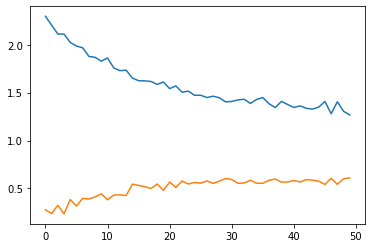

In [9]:
plt.plot(serverTestMetrics)


In [10]:
%tensorboard --logdir logs/ 

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 35568.

In [75]:
testAcc=[]*numberOfTraingRounds
testLoss=[]*numberOfTraingRounds
for i in range(0,numberOfTraingRounds):
    testAcc.append(trainingMetrics[i][1])
    testLoss.append(trainingMetrics[i][0])
k = np.array(testLoss)

In [81]:
k.

2.2109134197235107

In [77]:
np.savetxt("loss_history.txt", np.array(testLoss))

In [25]:
meanSINR = int(np.random.normal(15, 2.5, 1))
print(meanSINR)

11


In [35]:
np.round((np.random.normal(meanSINR, 1, 1)[0]), 2)

12.21

In [ ]:
raise SystemExit("Stop right there!")
